In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import gc
import pdet
import fpfs
import fitsio
import numpy as np
from fpfs import pltutil
import matplotlib.pylab as plt
import numpy.lib.recfunctions as rfn

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally

ver='try2'
gver='basic2'
dver='cut16'
wrkDir=os.environ['homeWrk']
simDir=os.path.join(wrkDir,'FPFS2/sim/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#nver='var1em9' # 'var0em0'#
nver='var7em3' # 'var0em0'#
#nver='var0em0' # 'var0em0'#
# read noiseless data
mm1=[]
mm2=[]
for _i in range(1000):
    _a1=fitsio.read(os.path.join(simDir,'srcfs3_%sCenter-%s_%s/psf60/fpfs-%s-%04d-g1-0000.fits' %(gver,nver,ver,dver,_i)))
    _a2=fitsio.read(os.path.join(simDir,'srcfs3_%sCenter-%s_%s/psf60/fpfs-%s-%04d-g1-2222.fits' %(gver,nver,ver,dver,_i)))
    mm1.append(_a1)
    mm2.append(_a2)
    del _a1,_a2#,msk1,msk2
mm1 =   rfn.stack_arrays(mm1,usemask=False)
mm2 =   rfn.stack_arrays(mm2,usemask=False)
gc.collect()

6

/var/tmp/pbs.102958.idark/ipykernel_137520/1776453050.py:3: RuntimeWarning: invalid value encountered in log10
  m1   =   -2.5 * np.log10(mm1['fpfs_M00']/pix_scale**2.) + 27.


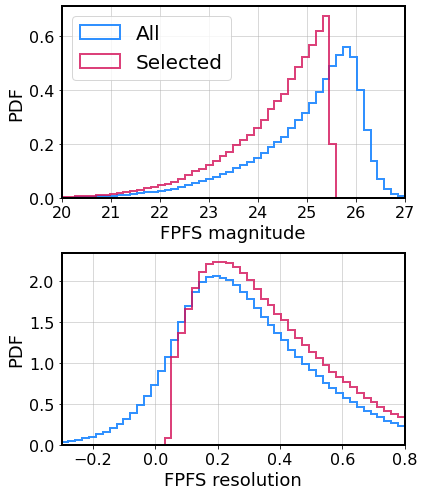

In [21]:
pix_scale=0.168
C=12*pix_scale**2.
m1   =   -2.5 * np.log10(mm1['fpfs_M00']/pix_scale**2.) + 27.
r2   =   (mm1['fpfs_M20']+mm1['fpfs_M00'])/(mm1['fpfs_M00'])
msk=(m1<25.5)&(r2>0.05)
plt.close()
fig,axes=pltutil.make_figure_axes(nx=1,ny=2,square=False)
ax=axes[0]
ax.hist(m1,bins=50,histtype='step',density=True,linewidth=2.,color=pltutil.colors[1],range=(20,27),label='All')
ax.hist(m1[msk],bins=50,histtype='step',density=True,linewidth=2.,color=pltutil.colors[2],range=(20,27),label='Selected')
ax.legend(loc='upper left')
ax.set_xlim(20,27)
ax.set_xlabel('FPFS magnitude')
ax.set_ylabel('PDF')
ax.grid()

ax=axes[1]
ax.hist(r2,bins=50,histtype='step',density=True,linewidth=2.,color=pltutil.colors[1],range=(-0.3,0.8))
ax.hist(r2[msk],bins=50,histtype='step',density=True,linewidth=2.,color=pltutil.colors[2],range=(-0.3,0.8))
ax.set_xlim(-0.3,0.8)
ax.set_xlabel('FPFS resolution')
ax.set_ylabel('PDF')
ax.grid()
fig.tight_layout()

gc.collect()
fig.savefig('obsHist.pdf')

In [6]:
gc.collect()
Const  =   6e-2
noirev =   True
ellM1  =   fpfs.catutil.fpfsM2E(mm1,const=Const,noirev=noirev)
ellM2  =   fpfs.catutil.fpfsM2E(mm2,const=Const,noirev=noirev)
gc.collect()

0

0.0
0.06
0.12
0.18
0.24
0.3
0.36
0.42


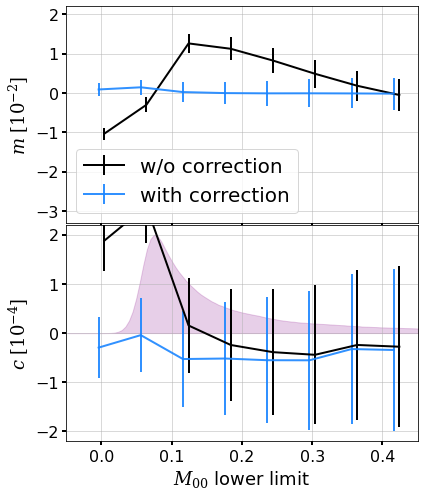

In [8]:
if False:
    del fs1,fs2
gc.collect()
use_sig=False
fs1=fpfs.base.Summary(mm1,ellM1,use_sig)
fs2=fpfs.base.Summary(mm2,ellM2,use_sig)

selnm=['R2']
dcc=0.06 # delta cut
cutB=0.
cutsig=[0.08]

x=[]
y1=[];y2=[];yerr=[]
z1=[];z2=[];zerr=[]
for i in range(0,8):
    # clean outcome
    fs1.clear_outcomes()
    fs2.clear_outcomes()
    
    cut=cutB+dcc*i
    print(cut)
    cut=[cut]
    # weight array
    fs1.update_selection_weight(selnm,cut,cutsig);fs2.update_selection_weight(selnm,cut,cutsig)
    fs1.update_selection_bias(selnm,cut,cutsig);fs2.update_selection_bias(selnm,cut,cutsig)
    fs1.update_ellsum();fs2.update_ellsum()
    de   = fs2.sumE1-fs1.sumE1
    eA   = (fs1.sumE1+fs2.sumE1)/2.
    eAR  = (fs1.sumE1+fs2.sumE1+fs1.corE1+fs2.corE1)/2.
    rave = (fs1.sumR1+fs2.sumR1)/2.
    raveR= (fs1.sumR1+fs2.sumR1+fs1.corR1+fs2.corR1)/2.
    x.append(cut[-1])
    y1.append(de/rave/0.04-1);y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR/0.04)
    z1.append(eA/rave);z2.append(eAR/rave)
    zerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR)
# make plot
plt.close()
fig,axes=pltutil.make_figure_axes(ny=2,nx=1,square=False)
ax=axes[0]
xlabel='$M_{00}$ lower limit';
ax.errorbar(np.array(x)+0.004,np.array(y1)*1e2,np.array(yerr)*1e2,label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)-0.004,np.array(y2)*1e2,np.array(yerr)*1e2,label='with correction',color=pltutil.colors[1])
ax.set_ylabel('$m$ $[10^{-2}]$',fontsize=18)
ax.set_xlim(-0.05,0.45)
ax.set_ylim(-3.3,2.2)
ax.tick_params(width=2,size=4)
hist,bins=np.histogram(fs1.mm['fpfs_M00'],range=(-0.05,0.46),bins=100,density=True)
cbin=(bins[1:]+bins[:-1])/2.
sf=hist.max()/2.
hist=hist/sf
ax.set_xticklabels([])
ax.grid()
ax.legend()

ax=axes[1]
ax.errorbar(np.array(x)+0.004,np.array(z1)*1e4,np.array(zerr)*1e4,label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)-0.004,np.array(z2)*1e4,np.array(zerr)*1e4,label='with correction',color=pltutil.colors[1])
ax.set_ylabel('$c$ $[10^{-4}]$',fontsize=18)
ax.set_xlim(-0.05,0.45)
ax.set_ylim(-2.2,2.2)
ax.tick_params(width=2,size=4)
ax.set_xlabel(xlabel,fontsize=18)
ax.fill_between(cbin,hist,color=pltutil.colors[-1],alpha=0.2)
ax.grid()

plt.tight_layout(h_pad=-0.2)

0.0
0.06
0.12
0.18
0.24
0.3
0.36
0.42


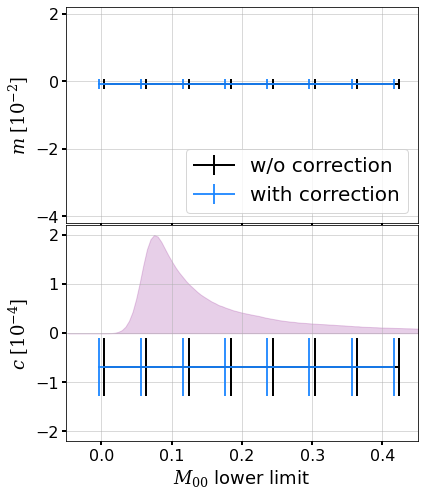

In [12]:
del fs1,fs2
gc.collect()
use_sig=False
fs1=fpfs.base.Summary(mm1,ellM1,use_sig)
fs2=fpfs.base.Summary(mm2,ellM2,use_sig)

selnm=['M00']
dcc=0.06 # delta cut
cutB=0.0
cutsig=[0.006,0.02,0.02]

x=[]
y1=[];y2=[];yerr=[]
z1=[];z2=[];zerr=[]
for i in range(0,8):
    # clean outcome
    fs1.clear_outcomes()
    fs2.clear_outcomes()
    
    cut=cutB+dcc*i
    print(cut)
    cut=[0.002,cut/2.5,cut]
    # weight array
    fs1.update_selection_weight(selnm,cut,cutsig);fs2.update_selection_weight(selnm,cut,cutsig)
    fs1.update_selection_bias(selnm,cut,cutsig);fs2.update_selection_bias(selnm,cut,cutsig)
    fs1.update_ellsum();fs2.update_ellsum()
    de   = fs2.sumE1-fs1.sumE1
    eA   = (fs1.sumE1+fs2.sumE1)/2.
    eAR  = (fs1.sumE1+fs2.sumE1+fs1.corE1+fs2.corE1)/2.
    rave = (fs1.sumR1+fs2.sumR1)/2.
    raveR= (fs1.sumR1+fs2.sumR1+fs1.corR1+fs2.corR1)/2.
    x.append(cut[-1])
    y1.append(de/rave/0.04-1);y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR/0.04)
    z1.append(eA/rave);z2.append(eAR/rave)
    zerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR)
# make plot
plt.close()
fig,axes=pltutil.make_figure_axes(ny=2,nx=1,square=False)
ax=axes[0]
xlabel='$M_{00}$ lower limit';
ax.errorbar(np.array(x)+0.004,np.array(y1)*1e2,np.array(yerr)*1e2,label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)-0.004,np.array(y2)*1e2,np.array(yerr)*1e2,label='with correction',color=pltutil.colors[1])
ax.set_ylabel('$m$ $[10^{-2}]$',fontsize=18)
ax.set_xlim(-0.05,0.45)
ax.set_ylim(-4.2,2.2)
ax.tick_params(width=2,size=4)
hist,bins=np.histogram(fs1.mm['fpfs_M00'],range=(-0.05,0.46),bins=100,density=True)
cbin=(bins[1:]+bins[:-1])/2.
sf=hist.max()/2.
hist=hist/sf
ax.set_xticklabels([])
ax.grid()
ax.legend(loc='lower right')

ax=axes[1]
ax.errorbar(np.array(x)+0.004,np.array(z1)*1e4,np.array(zerr)*1e4,label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)-0.004,np.array(z2)*1e4,np.array(zerr)*1e4,label='with correction',color=pltutil.colors[1])
ax.set_ylabel('$c$ $[10^{-4}]$',fontsize=18)
ax.set_xlim(-0.05,0.45)
ax.set_ylim(-2.2,2.2)
ax.tick_params(width=2,size=4)
ax.set_xlabel(xlabel,fontsize=18)
ax.fill_between(cbin,hist,color=pltutil.colors[-1],alpha=0.2)
ax.grid()

plt.tight_layout(h_pad=-0.2)

0.1
0.16
0.22
0.28
0.33999999999999997
0.4


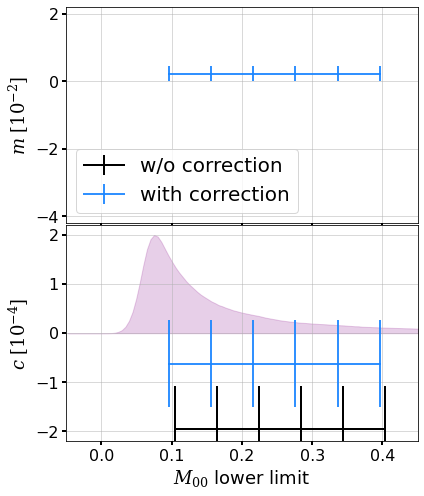

In [10]:
del fs1,fs2
gc.collect()
use_sig=False
fs1=fpfs.base.Summary(mm1,ellM1,use_sig)
fs2=fpfs.base.Summary(mm2,ellM2,use_sig)

selnm=['detect']
dcc=0.06 # delta cut
cutB=0.1
cutsig=[0.006,0.02,0.02]

x=[]
y1=[];y2=[];yerr=[]
z1=[];z2=[];zerr=[]
for i in range(0,6):
    # clean outcome
    fs1.clear_outcomes()
    fs2.clear_outcomes()
    
    cut=cutB+dcc*i
    print(cut)
    cut=[0.002,cut/2.5,cut]
    # weight array
    fs1.update_selection_weight(selnm,cut,cutsig);fs2.update_selection_weight(selnm,cut,cutsig)
    fs1.update_selection_bias(selnm,cut,cutsig);fs2.update_selection_bias(selnm,cut,cutsig)
    fs1.update_ellsum();fs2.update_ellsum()
    de   = fs2.sumE1-fs1.sumE1
    eA   = (fs1.sumE1+fs2.sumE1)/2.
    eAR  = (fs1.sumE1+fs2.sumE1+fs1.corE1+fs2.corE1)/2.
    rave = (fs1.sumR1+fs2.sumR1)/2.
    raveR= (fs1.sumR1+fs2.sumR1+fs1.corR1+fs2.corR1)/2.
    x.append(cut[-1])
    y1.append(de/rave/0.04-1);y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR/0.04)
    z1.append(eA/rave);z2.append(eAR/rave)
    zerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR)
# make plot
plt.close()
fig,axes=pltutil.make_figure_axes(ny=2,nx=1,square=False)
ax=axes[0]
xlabel='$M_{00}$ lower limit';
ax.errorbar(np.array(x)+0.004,np.array(y1)*1e2,np.array(yerr)*1e2,label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)-0.004,np.array(y2)*1e2,np.array(yerr)*1e2,label='with correction',color=pltutil.colors[1])
ax.set_ylabel('$m$ $[10^{-2}]$',fontsize=18)
ax.set_xlim(-0.05,0.45)
ax.set_ylim(-4.2,2.2)
ax.tick_params(width=2,size=4)
hist,bins=np.histogram(fs1.mm['fpfs_M00'],range=(-0.05,0.46),bins=100,density=True)
cbin=(bins[1:]+bins[:-1])/2.
sf=hist.max()/2.
hist=hist/sf
ax.set_xticklabels([])
ax.grid()
ax.legend()

ax=axes[1]
ax.errorbar(np.array(x)+0.004,np.array(z1)*1e4,np.array(zerr)*1e4,label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)-0.004,np.array(z2)*1e4,np.array(zerr)*1e4,label='with correction',color=pltutil.colors[1])
ax.set_ylabel('$c$ $[10^{-4}]$',fontsize=18)
ax.set_xlim(-0.05,0.45)
ax.set_ylim(-2.2,2.2)
ax.tick_params(width=2,size=4)
ax.set_xlabel(xlabel,fontsize=18)
ax.fill_between(cbin,hist,color=pltutil.colors[-1],alpha=0.2)
ax.grid()

plt.tight_layout(h_pad=-0.2)